In [1]:
%%capture
!pip install llm --upgrade

#uncomment this line if you want to use groq
!llm install llm-groq


In [2]:
!llm keys set groq

Enter key: 


In [65]:
!llm models

OpenAI Chat: gpt-4o (aliases: 4o)
OpenAI Chat: chatgpt-4o-latest (aliases: chatgpt-4o)
OpenAI Chat: gpt-4o-mini (aliases: 4o-mini)
OpenAI Chat: gpt-4o-audio-preview
OpenAI Chat: gpt-4o-audio-preview-2024-12-17
OpenAI Chat: gpt-4o-audio-preview-2024-10-01
OpenAI Chat: gpt-4o-mini-audio-preview
OpenAI Chat: gpt-4o-mini-audio-preview-2024-12-17
OpenAI Chat: gpt-4.1 (aliases: 4.1)
OpenAI Chat: gpt-4.1-mini (aliases: 4.1-mini)
OpenAI Chat: gpt-4.1-nano (aliases: 4.1-nano)
OpenAI Chat: gpt-3.5-turbo (aliases: 3.5, chatgpt)
OpenAI Chat: gpt-3.5-turbo-16k (aliases: chatgpt-16k, 3.5-16k)
OpenAI Chat: gpt-4 (aliases: 4, gpt4)
OpenAI Chat: gpt-4-32k (aliases: 4-32k)
OpenAI Chat: gpt-4-1106-preview
OpenAI Chat: gpt-4-0125-preview
OpenAI Chat: gpt-4-turbo-2024-04-09
OpenAI Chat: gpt-4-turbo (aliases: gpt-4-turbo-preview, 4-turbo, 4t)
OpenAI Chat: gpt-4.5-preview-2025-02-27
OpenAI Chat: gpt-4.5-preview (aliases: gpt-4.5)
OpenAI Chat: o1
OpenAI Chat: o1-2024-12-17
OpenAI Chat: o1-preview
OpenAI Chat:

In [68]:
!llm --system """You are a Roman epigraphy specialist extracting data from inscriptions following the 'epigraphic habit' - the standardized conventions of Roman inscribed text. FIRST, classify the inscription type: FUNERARY, VOTIVE, DEDICATORY, HONORIFIC, BUILDING, MILESTONE, CURSE_TABLET, or GRAFFITI. Then extract all present fields in KEY: value format: INSCRIPTION_METADATA: - INSCRIPTION_TYPE (required) - FORMULA_OPENING (D.M., D.M.S., H.S.E., etc.) - FORMULA_CLOSING (common closings/abbreviations) - ABBREVIATIONS_EXPANDED (list any expanded abbreviations) ONOMASTIC_DATA: - PRAENOMEN, NOMEN, COGNOMEN (capture all name elements for each person mentioned) - FILIAL_RELATIONSHIP (filiation: son of X, daughter of X - preserve genitive form) - STATUS_MARKERS (free/freed/slave, where indicated) BIOGRAPHICAL_DATA: - OCCUPATION, MILITARY_UNIT, TRIBE - AGE_AT_DEATH (if funerary) - ORIGIN/ORIGO (hometown/region) SOCIAL_CONTEXT: - DEDICATOR (who commissioned inscription) - DEDICATOR_RELATIONSHIP (spouse, child, freedman, etc.) - RELIGIOUS_DEDICATION (divine addressee) TEXTUAL_NOTES: - UNUSUAL_ELEMENTS (non-standard formulas, missing conventions) - FRAGMENTARY_NOTES (damaged sections, uncertain readings)Return ONLY extracted data as jsonl. NO commentary.""" --save extractor

In [6]:
# clean up target data
import csv
import re
import json
from collections import Counter

class LeidenProcessor:
    """Convert Leiden conventions to clean transcription"""

    # Map abbreviations to their expansions
    # Capitalize proper nouns, keep others lowercase
    ABBREV_PROPER = {  # Names (capitalize)
        'Q': 'Quintus', 'C': 'Caius', 'M': 'Marcus', 'L': 'Lucius',
        'T': 'Titus', 'P': 'Publius', 'D': 'Dis', 'A': 'Aulus',
        'Cn': 'Gnaeus', 'TI': 'Tiberius', 'S': 'Sextus', 'N': 'Numerius',
    }

    ABBREV_COMMON = {  # Common words (lowercase)
        'a': 'animo', 'l': 'libens', 'v': 'votum', 'p': 'posuit',
        's': 'sacrum', 'f': 'fecit', 'm': 'mensis', 'an': 'anno',
        'ann': 'annorum', 'h': 'hic', 'e': 'est', 'pos': 'posuit',
        't': 'tibi', 'd': 'de', 'sit': 'sit'
    }

    @staticmethod
    def process(leiden_text):
        """Full pipeline: Leiden → clean transcription"""

        # Step 1: Remove damage markers [3] (n unknown letters)
        text = re.sub(r'\[\d+\]', '', leiden_text)

        # Step 2: Remove question marks and uncertain markers
        text = re.sub(r'\?', '', text)
        text = re.sub(r'\[([^\]]*)\]', r'\1', text)  # [text] → text

        # Step 3: Join words broken across lines intelligently
        # Handle patterns like "Gem/ellian" or "ann]or/um"
        # Remove line breaks only when joining word fragments
        text = re.sub(r'([a-z])/([a-z])', r'\1\2', text, flags=re.IGNORECASE)
        text = re.sub(r'(\])/([a-z])', r'\1\2', text, flags=re.IGNORECASE)

        # Step 4: Expand abbreviations with proper case handling
        def expand_abbrev(match):
            abbrev = match.group(1)
            expansion = match.group(2) if match.group(2) else ""

            # If expansion provided in parentheses, use it
            if expansion:
                # Keep expansion as-is, preserve case
                return abbrev + expansion

            # Try proper noun abbreviations first
            if abbrev in LeidenProcessor.ABBREV_PROPER:
                return LeidenProcessor.ABBREV_PROPER[abbrev]

            # Try common abbreviations
            if abbrev.lower() in LeidenProcessor.ABBREV_COMMON:
                return LeidenProcessor.ABBREV_COMMON[abbrev.lower()]

            # Return original if not found
            return abbrev

        # Pattern: X(expansion) captures abbreviation and optional expansion text
        text = re.sub(r'([A-Za-z]+)\(([^)]*)\)', expand_abbrev, text)

        # Step 5: Clean line break markers and multiple spaces
        text = text.replace('/', ' ')
        text = text.replace('\\', ' ')
        text = re.sub(r'\s+', ' ', text).strip()

        # Step 6: Remove remaining brackets and junk
        text = re.sub(r'[\[\]]', '', text)

        # Step 7: Capitalize only first letter and proper nouns
        # Simple heuristic: capitalize after space, but preserve lowercase articles/prepositions
        LOWERCASE_WORDS = {'et', 'de', 'a', 'in', 'ex', 'ab'}

        words = text.split()
        result = []

        for i, word in enumerate(words):
            if i == 0:  # First word always capitalized
                result.append(word.capitalize())
            elif word.lower() in LOWERCASE_WORDS:
                result.append(word.lower())
            elif word[0].isupper():  # Already capitalized (likely a name)
                result.append(word)
            else:
                result.append(word.capitalize())

        return ' '.join(result)



In [66]:
import pandas as pd

# Read CSV (adjust filename to match your upload)
df = pd.read_csv('actual_inscriptions.csv')  # or whatever your file is named

print(f"Loaded {len(df)} inscriptions\n")

# Process all inscriptions
records = []
for idx, row in df.iterrows():
    leiden_text = row.get('text', '') if isinstance(row, dict) else row['text']

    if not leiden_text:
        continue

    transcription = LeidenProcessor.process(leiden_text)

    record = {
        "id": f"actual_{idx}",
        "text": transcription,
        "leiden_source": leiden_text,
        "annotations": []
    }
    records.append(record)

print(f"Processed {len(records)} inscriptions")

# Show samples
print("\nFirst 3 samples:")
for rec in records[:3]:
    print(f"\n  Leiden:        {rec['leiden_source']}")
    print(f"  Transcription: {rec['text']}")

Loaded 138 inscriptions

Processed 138 inscriptions

First 3 samples:

  Leiden:        Iovi / Optimo / Maximo / Q(uintus) Cassius / Cassianus / a(nimo) l(ibens) [v(otum) p(osuit)]
  Transcription: Iovi Optimo Maximo Quintus Cassius Cassianus Animo Libens Votum Posuit

  Leiden:        D(is) M(anibus) s(acrum) / Sycecale / v(ixit) an(n)o m(ensibus) [V] / soror[es] / Tricism[a] / Salcea / et Veget[a]
  Transcription: Dis Manibus Sacrum Sycecale Vixit Anno Mensibus V Sorores Tricisma Salcea et Vegeta

  Leiden:        Fig(lina) Gem/ellian[a]
  Transcription: Figlina Gemelliana


In [ ]:
import os
import subprocess

output_dir = 'resolved'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

for i, record in enumerate(records, 1):
    text = record['text']
    output_path = os.path.join(output_dir, f"{record['id']}.txt")

    # Execute the command
    try:
        with open(output_path, 'w') as f:
            subprocess.run(
                ["llm", "-m", "groq/qwen/qwen3-32b", "-t", "extractor", text],
                stdout=f,
                check=True
            )
        print(f"Processed {record['id']} successfully")
    except subprocess.CalledProcessError as e:
        print(f"Error processing {record['id']}: {e}")

In [72]:
# for dealing with output of qwen & its <think> mode
import json
import re
from pathlib import Path
import pandas as pd
from typing import List, Dict, Any

def extract_json_from_file(filepath: str) -> Dict[str, Any]:
    """
    Extract JSON from a text file that contains <think></think> tags followed by JSONL.
    Returns the parsed JSON object, or None if extraction fails.
    """
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()

        # Remove <think></think> tags and everything before the JSON
        # Match everything after the closing </think> tag
        match = re.search(r'</think>\s*(\{.*\})', content, re.DOTALL)

        if match:
            json_str = match.group(1)
            # Parse the JSON
            json_obj = json.loads(json_str)
            return json_obj
        else:
            print(f"Warning: No JSON found in {filepath}")
            return None
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON in {filepath}: {e}")
        return None
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None

def process_directory(directory: str, output_jsonl: str = "compiled_inscriptions.jsonl") -> pd.DataFrame:
    """
    Process all .txt files in a directory, extract JSON, compile into JSONL, and return as DataFrame.
    """
    resolved_dir = Path(directory)

    if not resolved_dir.exists():
        print(f"Directory {directory} does not exist")
        return pd.DataFrame()

    # Collect all JSON objects
    json_objects = []
    txt_files = list(resolved_dir.glob("*.txt"))

    print(f"Found {len(txt_files)} text files")

    for filepath in sorted(txt_files):
        print(f"Processing: {filepath.name}")
        json_obj = extract_json_from_file(str(filepath))
        if json_obj is not None:
            # Add filename for reference
            json_obj['_source_file'] = filepath.name
            json_objects.append(json_obj)

    # Write compiled JSONL file
    output_path = Path(directory) / output_jsonl
    with open(output_path, 'w', encoding='utf-8') as f:
        for obj in json_objects:
            f.write(json.dumps(obj) + '\n')

    print(f"\nCompiled {len(json_objects)} records to {output_path}")

    # Convert to DataFrame
    df = pd.DataFrame(json_objects)
    print(f"DataFrame shape: {df.shape}")

    return df

def flatten_nested_json(df: pd.DataFrame) -> pd.DataFrame:
    """
    Flatten nested JSON structures for easier analysis.
    Useful for columns with nested objects/arrays.
    """
    df_flat = df.copy()

    # For nested objects like INSCRIPTION_METADATA, create separate columns
    if 'INSCRIPTION_METADATA' in df_flat.columns:
        metadata_cols = pd.json_normalize(df_flat['INSCRIPTION_METADATA'])
        metadata_cols.columns = ['METADATA_' + col for col in metadata_cols.columns]
        df_flat = pd.concat([df_flat.drop('INSCRIPTION_METADATA', axis=1), metadata_cols], axis=1)

    if 'SOCIAL_CONTEXT' in df_flat.columns:
        social_cols = pd.json_normalize(df_flat['SOCIAL_CONTEXT'])
        social_cols.columns = ['SOCIAL_' + col for col in social_cols.columns]
        df_flat = pd.concat([df_flat.drop('SOCIAL_CONTEXT', axis=1), social_cols], axis=1)

    if 'ONOMASTIC_DATA' in df_flat.columns:
        # For arrays, we might want to keep as-is or extract first element
        # This example keeps the array structure
        pass

    return df_flat

if __name__ == "__main__":
    # Process the /resolved directory
    df = process_directory("resolved")

    if not df.empty:
        print("\nDataFrame preview:")
        print(df.head())

        print("\nDataFrame info:")
        print(df.info())

        # Optionally flatten for analysis
        df_flat = flatten_nested_json(df)
        print("\nFlattened DataFrame columns:")
        print(df_flat.columns.tolist())
        print(df_flat.head())
    else:
        print("No data to process")

Found 138 text files
Processing: actual_0.txt
Processing: actual_1.txt
Processing: actual_10.txt
Processing: actual_100.txt
Processing: actual_101.txt
Processing: actual_102.txt
Error parsing JSON in resolved/actual_102.txt: Extra data: line 1 column 492 (char 491)
Processing: actual_103.txt
Processing: actual_104.txt
Processing: actual_105.txt
Processing: actual_106.txt
Processing: actual_107.txt
Processing: actual_108.txt
Processing: actual_109.txt
Processing: actual_11.txt
Processing: actual_110.txt
Processing: actual_111.txt
Processing: actual_112.txt
Processing: actual_113.txt
Processing: actual_114.txt
Error parsing JSON in resolved/actual_114.txt: Extra data: line 1 column 286 (char 285)
Processing: actual_115.txt
Processing: actual_116.txt
Processing: actual_117.txt
Error parsing JSON in resolved/actual_117.txt: Extra data: line 1 column 347 (char 346)
Processing: actual_118.txt
Processing: actual_119.txt
Processing: actual_12.txt
Processing: actual_120.txt
Processing: actual_1

In [87]:
import json
import pandas as pd
from pathlib import Path
from typing import Any, Dict, List
import re

def normalize_value(value: Any, field_name: str = None) -> Any:
    """
    Normalize various data types to clean values.
    Handles lists, strings, empty values, nested dicts, and type mismatches.
    """

    # Handle None and null
    if value is None or value == 'None' or value == 'null':
        return None

    # Handle empty values (empty strings, empty lists, etc.)
    if value == '' or value == ':' or value == '[]':
        return None

    # Handle nested dicts (convert to string representation for now)
    if isinstance(value, dict):
        # For nested dicts, join keys and values
        if len(value) == 0:
            return None
        items = []
        for k, v in value.items():
            if isinstance(v, list) and v:
                items.append(f"{k}: {'; '.join(str(x) for x in v)}")
            elif v:
                items.append(f"{k}: {v}")
        return '; '.join(items) if items else None

    # Handle lists
    if isinstance(value, list):
        if len(value) == 0:
            return None
        # Filter and clean list items
        cleaned_list = []
        for v in value:
            if v is None or v == '' or v == 'None':
                continue
            if isinstance(v, str):
                v = v.strip()
                if v:
                    cleaned_list.append(v)
            elif v:
                cleaned_list.append(str(v))

        if len(cleaned_list) == 0:
            return None
        elif len(cleaned_list) == 1:
            return cleaned_list[0]
        else:
            # Join multiple items
            return '; '.join(cleaned_list)

    # Convert to string and trim
    value_str = str(value).strip() if value is not None else None

    if not value_str or value_str in ['', 'None', 'null', '[]']:
        return None

    # Field-specific normalizations
    if field_name and 'DEDICATION' in field_name.upper():
        # Normalize religious dedications
        value_lower = value_str.lower()

        # Dis Manibus variations (includes Manes)
        if any(x in value_lower for x in ['dis manibus', 'di manes', "'manes'", '"manes"']):
            return 'Dis Manibus'
        if value_lower == 'manes':
            return 'Dis Manibus'

        # Jupiter variations
        if any(x in value_lower for x in ['iovi optimo maximo', 'iovis optimi maximi', 'iovem', 'iupiter', 'jovis']):
            return 'Jupiter'

        # Serapis
        if 'serap' in value_lower:
            return 'Serapis'

        # Mars
        if 'mart' in value_lower:
            return 'Mars'

        # Neptune
        if 'neptun' in value_lower:
            return 'Neptune'

        # Vesta
        if 'vest' in value_lower:
            return 'Vesta'

        # Deified emperors / Augustus
        if 'august' in value_lower or 'divorum' in value_lower:
            return 'Divorum/Augustus'

        # Terra/Earth
        if 'terra' in value_lower or 'sit tibi' in value_lower:
            return 'Terra/Underworld'

        # Dea/Goddess
        if 'dea' in value_lower:
            return value_str  # Keep specific goddess names

    return value_str if value_str else None

def clean_inscription_record(record: Dict[str, Any]) -> Dict[str, Any]:
    """
    Clean and normalize a single inscription record.
    Handles both dict and list-based ONOMASTIC_DATA structures.
    """
    cleaned = record.copy()

    # Clean INSCRIPTION_METADATA
    if 'INSCRIPTION_METADATA' in cleaned and isinstance(cleaned['INSCRIPTION_METADATA'], dict):
        meta = cleaned['INSCRIPTION_METADATA']
        meta['INSCRIPTION_TYPE'] = normalize_value(meta.get('INSCRIPTION_TYPE'), 'TYPE')
        meta['FORMULA_OPENING'] = normalize_value(meta.get('FORMULA_OPENING'), 'FORMULA')
        meta['FORMULA_CLOSING'] = normalize_value(meta.get('FORMULA_CLOSING'), 'FORMULA')

    # Clean SOCIAL_CONTEXT
    if 'SOCIAL_CONTEXT' in cleaned and isinstance(cleaned['SOCIAL_CONTEXT'], dict):
        social = cleaned['SOCIAL_CONTEXT']
        # Normalize RELIGIOUS_DEDICATION which might be string or list
        ded_raw = social.get('RELIGIOUS_DEDICATION')
        social['RELIGIOUS_DEDICATION'] = normalize_value(ded_raw, 'RELIGIOUS_DEDICATION')

        social['DEDICATOR'] = normalize_value(social.get('DEDICATOR'), 'DEDICATOR')
        social['DEDICATOR_RELATIONSHIP'] = normalize_value(
            social.get('DEDICATOR_RELATIONSHIP'),
            'RELATIONSHIP'
        )

    # Clean BIOGRAPHICAL_DATA
    if 'BIOGRAPHICAL_DATA' in cleaned and isinstance(cleaned['BIOGRAPHICAL_DATA'], dict):
        bio = cleaned['BIOGRAPHICAL_DATA']
        bio['MILITARY_UNIT'] = normalize_value(bio.get('MILITARY_UNIT'), 'MILITARY')
        bio['OCCUPATION'] = normalize_value(bio.get('OCCUPATION'), 'OCCUPATION')
        bio['ORIGIN'] = normalize_value(bio.get('ORIGIN'), 'ORIGIN')
        bio['ORIGIN/ORIGO'] = normalize_value(bio.get('ORIGIN/ORIGO'), 'ORIGIN')  # Handle variant key
        bio['TRIBE'] = normalize_value(bio.get('TRIBE'), 'TRIBE')

        # Handle age - can be text like "Anno Mensibus V" or numeric
        age = bio.get('AGE_AT_DEATH')
        if age is not None:
            age_str = str(age).strip()
            # Try to extract numeric part if present
            try:
                # Look for number at start or in "X years" format
                import re
                match = re.search(r'\d+', age_str)
                if match:
                    age_num = int(match.group())
                    bio['AGE_AT_DEATH'] = age_num if age_num > 0 else None
                else:
                    bio['AGE_AT_DEATH'] = None
            except (ValueError, TypeError):
                bio['AGE_AT_DEATH'] = None
        else:
            bio['AGE_AT_DEATH'] = None

    # Clean ONOMASTIC_DATA - handle both dict and list formats
    if 'ONOMASTIC_DATA' in cleaned:
        onomastic = cleaned['ONOMASTIC_DATA']

        if isinstance(onomastic, dict):
            # Current structure: dict with name fields that might be lists/strings/nested dicts
            cleaned_onomastic = {}

            # Standard fields
            for field in ['PRAENOMEN', 'NOMEN', 'COGNOMEN']:
                val = onomastic.get(field)
                cleaned_onomastic[field] = normalize_value(val, 'NAME')

            # Relationship field (might be nested)
            for field in ['FILIAL_RELATIONSHIP', 'STATUS_MARKERS']:
                val = onomastic.get(field)
                if isinstance(val, dict):
                    # Nested dict - convert to string
                    cleaned_onomastic[field] = normalize_value(val, field)
                else:
                    cleaned_onomastic[field] = normalize_value(val, field)

            # Keep other fields that might be present
            for field in onomastic.keys():
                if field not in cleaned_onomastic:
                    cleaned_onomastic[field] = normalize_value(onomastic[field], field)

            cleaned['ONOMASTIC_DATA'] = cleaned_onomastic

        elif isinstance(onomastic, list):
            # Legacy list format
            cleaned_onomastic = []
            for person in onomastic:
                if isinstance(person, dict):
                    cleaned_person = {
                        'PRAENOMEN': normalize_value(person.get('PRAENOMEN'), 'NAME'),
                        'NOMEN': normalize_value(person.get('NOMEN'), 'NAME'),
                        'COGNOMEN': normalize_value(person.get('COGNOMEN'), 'NAME'),
                        'FILIAL_RELATIONSHIP': normalize_value(person.get('FILIAL_RELATIONSHIP'), 'FILIATION'),
                        'STATUS_MARKERS': normalize_value(person.get('STATUS_MARKERS'), 'STATUS'),
                    }
                    cleaned_onomastic.append(cleaned_person)
            cleaned['ONOMASTIC_DATA'] = cleaned_onomastic

    return cleaned

def clean_jsonl_file(input_path: str, output_path: str = None) -> pd.DataFrame:
    """
    Clean a JSONL file by normalizing all records.
    Returns cleaned DataFrame and optionally writes to new JSONL.
    """

    if output_path is None:
        output_path = str(Path(input_path).parent /
                         (Path(input_path).stem + '_cleaned.jsonl'))

    cleaned_records = []
    errors = []

    print(f"Reading: {input_path}")

    with open(input_path, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f, 1):
            if line.strip():
                try:
                    record = json.loads(line)
                    cleaned = clean_inscription_record(record)
                    cleaned_records.append(cleaned)
                except json.JSONDecodeError as e:
                    errors.append(f"Line {line_num}: JSON parse error - {e}")
                except Exception as e:
                    errors.append(f"Line {line_num}: {type(e).__name__} - {e}")

    # Report errors
    if errors:
        print(f"\n⚠️  Encountered {len(errors)} errors during cleaning:")
        for error in errors[:10]:  # Show first 10
            print(f"  {error}")
        if len(errors) > 10:
            print(f"  ... and {len(errors) - 10} more")

    # Write cleaned JSONL
    with open(output_path, 'w', encoding='utf-8') as f:
        for record in cleaned_records:
            f.write(json.dumps(record) + '\n')

    print(f"\n✓ Cleaned {len(cleaned_records)} records")
    print(f"  Output: {output_path}")

    # Convert to DataFrame
    df = pd.DataFrame(cleaned_records)

    return df, output_path

def generate_cleaning_report(original_jsonl: str, cleaned_df: pd.DataFrame):
    """
    Generate a report showing before/after statistics.
    """

    print("\n" + "=" * 70)
    print("DATA CLEANING REPORT")
    print("=" * 70)

    # Religious dedications
    print("\nRELIGIOUS_DEDICATIONS - Before vs After:")

    original_dedications = []
    with open(original_jsonl, 'r') as f:
        for line in f:
            if line.strip():
                try:
                    record = json.loads(line)
                    social = record.get('SOCIAL_CONTEXT', {})
                    if isinstance(social, dict):
                        original_dedications.append(social.get('RELIGIOUS_DEDICATION'))
                except:
                    pass

    before_unique = len(set(str(d) for d in original_dedications))
    after_dedications = cleaned_df['SOCIAL_CONTEXT'].apply(
        lambda x: x.get('RELIGIOUS_DEDICATION') if isinstance(x, dict) else None
    ).dropna()
    after_unique = len(after_dedications.unique())

    print(f"  Before: {before_unique} unique values")
    print(f"  After:  {after_unique} unique values")
    print(f"  Reduction: {before_unique - after_unique} ({100 * (before_unique - after_unique) / before_unique:.1f}%)")

    # Show top dedications after cleaning
    if len(after_dedications) > 0:
        print(f"\n  Top religious dedications:")
        for deity, count in after_dedications.value_counts().head(10).items():
            print(f"    {deity}: {count}")

    # Inscription types
    print("\nINSCRIPTION_TYPES - Summary:")
    types = cleaned_df['INSCRIPTION_METADATA'].apply(
        lambda x: x.get('INSCRIPTION_TYPE') if isinstance(x, dict) else None
    )
    for itype, count in types.value_counts().items():
        print(f"  {itype}: {count}")

    # Military units
    print("\nMILITARY_UNITS - Summary:")
    units = cleaned_df['BIOGRAPHICAL_DATA'].apply(
        lambda x: x.get('MILITARY_UNIT') if isinstance(x, dict) else None
    ).dropna()

    if len(units) > 0:
        for unit, count in units.value_counts().head(10).items():
            print(f"  {unit}: {count}")
    else:
        print("  None found")

    print("\n" + "=" * 70)

if __name__ == "__main__":
    # Clean the main JSONL file
    try:
        df_cleaned, output_file = clean_jsonl_file(
            'resolved/compiled_inscriptions.jsonl'
        )

        # Generate cleaning report
        generate_cleaning_report(
            'resolved/compiled_inscriptions.jsonl',
            df_cleaned
        )

        print(f"\n✓ Cleaned data ready for analysis")
        print(f"  Use: python analyze_inscriptions.py")
        print(f"  (It will automatically use the cleaned JSONL)")

    except FileNotFoundError:
        print("Error: compiled_inscriptions.jsonl not found in /resolved")
        print("Run process_epigraphic_responses.py first")

Reading: resolved/compiled_inscriptions.jsonl

✓ Cleaned 117 records
  Output: resolved/compiled_inscriptions_cleaned.jsonl

DATA CLEANING REPORT

RELIGIOUS_DEDICATIONS - Before vs After:
  Before: 28 unique values
  After:  15 unique values
  Reduction: 13 (46.4%)

  Top religious dedications:
    Dis Manibus: 12
    Jupiter: 6
    Terra/Underworld: 2
    Divorum/Augustus: 2
    Dea Sancta Turubricensi: 1
    Ortygius (Ortygi) – possibly a local deity or cult figure: 1
    Manes: 1
    Sit Tibi Terra Levis: 1
    Votum (vow to deities): 1
    Animo (spirit): 1

INSCRIPTION_TYPES - Summary:
  FUNERARY: 80
  VOTIVE: 11
  DEDICATORY: 8
  GRAFFITI: 4
  HONORIFIC: 4
  BUILDING: 4
  FRAGMENTARY: 1
  UNKNOWN_FRAGMENT: 1
  Dedicatory: 1
  UNKNOWN/FRAGMENTARY: 1

MILITARY_UNITS - Summary:
  NA: 1
  Contubernio; Catulus: 1


✓ Cleaned data ready for analysis
  Use: python analyze_inscriptions.py
  (It will automatically use the cleaned JSONL)


In [90]:
import json
import pandas as pd
from pathlib import Path

def flatten_for_analysis(jsonl_path: str = "resolved/compiled_inscriptions.jsonl") -> dict:
    """
    Flatten the nested JSONL structure into separate analytical DataFrames.
    Returns dict with different analytical views of the data.
    """

    # Load raw data
    records = []
    with open(jsonl_path, 'r') as f:
        for line in f:
            if line.strip():
                records.append(json.loads(line))

    inscriptions_df = pd.DataFrame(records)

    # 1. INSCRIPTIONS TABLE - One row per inscription with flattened metadata
    inscriptions = []
    for idx, row in inscriptions_df.iterrows():
        meta = row['INSCRIPTION_METADATA'] if isinstance(row['INSCRIPTION_METADATA'], dict) else {}
        bio = row['BIOGRAPHICAL_DATA'] if isinstance(row['BIOGRAPHICAL_DATA'], dict) else {}
        social = row['SOCIAL_CONTEXT'] if isinstance(row['SOCIAL_CONTEXT'], dict) else {}

        # Normalize age (handle lists and strings)
        age = bio.get('AGE_AT_DEATH')
        if isinstance(age, list):
            age = age[0] if len(age) > 0 else None
        if age is not None:
            try:
                age = float(age) if str(age).strip() else None
            except (ValueError, TypeError):
                age = None

        inscriptions.append({
            'inscription_id': idx,
            'source_file': row.get('_source_file', ''),
            'inscription_type': meta.get('INSCRIPTION_TYPE'),
            'formula_opening': meta.get('FORMULA_OPENING'),
            'formula_closing': meta.get('FORMULA_CLOSING'),
            'occupation': bio.get('OCCUPATION'),
            'military_unit': bio.get('MILITARY_UNIT'),
            'tribe': bio.get('TRIBE'),
            'age_at_death': age,
            'origin': bio.get('ORIGIN'),
            'dedicator': social.get('DEDICATOR'),
            'dedicator_relationship': social.get('DEDICATOR_RELATIONSHIP'),
            'religious_dedication': social.get('RELIGIOUS_DEDICATION'),
        })

    inscriptions_df_flat = pd.DataFrame(inscriptions)

    # 2. PEOPLE TABLE - One row per person mentioned (from onomastic data)
    people = []
    for idx, row in inscriptions_df.iterrows():
        onomastic_list = row['ONOMASTIC_DATA']
        if isinstance(onomastic_list, list):
            for person_idx, person in enumerate(onomastic_list):
                if isinstance(person, dict):
                    people.append({
                        'person_id': f"{idx}_{person_idx}",
                        'inscription_id': idx,
                        'person_role': 'deceased' if row['INSCRIPTION_METADATA'].get('INSCRIPTION_TYPE') == 'FUNERARY' and person_idx == 0 else 'dedicator',
                        'praenomen': person.get('PRAENOMEN'),
                        'nomen': person.get('NOMEN'),
                        'cognomen': person.get('COGNOMEN'),
                        'full_name': ' '.join([p for p in [person.get('PRAENOMEN'), person.get('NOMEN'), person.get('COGNOMEN')] if p]),
                        'filial_relationship': person.get('FILIAL_RELATIONSHIP'),
                        'status': person.get('STATUS_MARKERS'),
                    })

    people_df = pd.DataFrame(people)

    # 3. SOCIAL_NETWORK TABLE - Relationships between people
    relationships = []
    for idx, row in inscriptions_df.iterrows():
        social = row['SOCIAL_CONTEXT'] if isinstance(row['SOCIAL_CONTEXT'], dict) else {}
        dedicator = social.get('DEDICATOR')
        relationship = social.get('DEDICATOR_RELATIONSHIP')

        if dedicator and relationship:
            onomastic = row['ONOMASTIC_DATA']
            if isinstance(onomastic, list) and len(onomastic) > 0:
                deceased = onomastic[0]
                if isinstance(deceased, dict):
                    deceased_name = ' '.join([p for p in [deceased.get('PRAENOMEN'), deceased.get('NOMEN'), deceased.get('COGNOMEN')] if p])
                    relationships.append({
                        'inscription_id': idx,
                        'from_person': deceased_name,
                        'to_person': dedicator,
                        'relationship_type': relationship,
                        'relationship_direction': 'dedicator_to_deceased'
                    })

    relationships_df = pd.DataFrame(relationships)

    # 4. MILITARY TABLE - Military officers and units
    military = []
    for idx, row in inscriptions_df.iterrows():
        bio = row['BIOGRAPHICAL_DATA'] if isinstance(row['BIOGRAPHICAL_DATA'], dict) else {}
        unit = bio.get('MILITARY_UNIT')

        if unit:
            onomastic = row['ONOMASTIC_DATA']
            if isinstance(onomastic, list) and len(onomastic) > 0:
                officer = onomastic[0]
                if isinstance(officer, dict):
                    officer_name = ' '.join([p for p in [officer.get('PRAENOMEN'), officer.get('NOMEN'), officer.get('COGNOMEN')] if p])
                    military.append({
                        'inscription_id': idx,
                        'officer_name': officer_name,
                        'rank': bio.get('OCCUPATION'),
                        'unit': unit,
                        'origin': bio.get('ORIGIN'),
                        'age_at_death': bio.get('AGE_AT_DEATH'),
                    })

    military_df = pd.DataFrame(military)

    # 5. DEITIES TABLE - Religious dedications
    deities = []
    for idx, row in inscriptions_df.iterrows():
        social = row['SOCIAL_CONTEXT'] if isinstance(row['SOCIAL_CONTEXT'], dict) else {}
        deity = social.get('RELIGIOUS_DEDICATION')

        # Normalize deity (handle lists and strings)
        if isinstance(deity, list):
            if len(deity) == 0:
                deity = None
            else:
                deity = deity[0] if len(deity) == 1 else '; '.join(str(d) for d in deity if d)
        elif deity:
            deity = str(deity).strip() if deity else None

        # Skip empty/null
        if not deity or deity in ['', 'None', 'null']:
            deity = None

        if deity:
            inscriptions_df_ref = inscriptions_df.iloc[idx]
            meta = inscriptions_df_ref.get('INSCRIPTION_METADATA', {})
            deities.append({
                'inscription_id': idx,
                'inscription_type': meta.get('INSCRIPTION_TYPE') if isinstance(meta, dict) else None,
                'deity': deity,
                'dedicator': social.get('DEDICATOR'),
                'origin': row['BIOGRAPHICAL_DATA'].get('ORIGIN') if isinstance(row['BIOGRAPHICAL_DATA'], dict) else None,
            })

    deities_df = pd.DataFrame(deities)

    return {
        'inscriptions': inscriptions_df_flat,
        'people': people_df,
        'relationships': relationships_df,
        'military': military_df,
        'deities': deities_df,
        'raw': inscriptions_df
    }

def export_analysis(analysis_dict: dict, output_dir: str = "resolved"):
    """Export all analysis DataFrames to CSV files"""
    output_path = Path(output_dir)

    for table_name, df in analysis_dict.items():
        if table_name != 'raw' and not df.empty:
            filename = f"analysis_{table_name}.csv"
            filepath = output_path / filename
            df.to_csv(filepath, index=False)
            print(f"Exported: {filename} ({len(df)} rows)")

def print_analysis_summary(analysis_dict: dict):
    """Print summary statistics from all tables"""

    print("\n" + "=" * 70)
    print("FLATTENED DATA ANALYSIS SUMMARY")
    print("=" * 70)

    # Inscriptions summary
    df_inscriptions = analysis_dict['inscriptions']
    print(f"\nINSCRIPTIONS TABLE: {len(df_inscriptions)} records")
    print(f"  Inscription types: {df_inscriptions['inscription_type'].nunique()}")
    print(f"  Types: {', '.join(df_inscriptions['inscription_type'].dropna().unique())}")

    # People summary
    df_people = analysis_dict['people']
    print(f"\nPEOPLE TABLE: {len(df_people)} individuals mentioned")
    print(f"  Unique names: {df_people['full_name'].nunique()}")
    print(f"  Status breakdown:")
    for status, count in df_people['status'].value_counts().items():
        if status:
            print(f"    {status}: {count}")

    # Relationships summary
    df_relationships = analysis_dict['relationships']
    if not df_relationships.empty:
        print(f"\nRELATIONSHIPS TABLE: {len(df_relationships)} relationships documented")
        print(f"  Relationship types:")
        for rel_type, count in df_relationships['relationship_type'].value_counts().items():
            print(f"    {rel_type}: {count}")
    else:
        print(f"\nRELATIONSHIPS TABLE: No relationships documented")

    # Military summary
    df_military = analysis_dict['military']
    if not df_military.empty:
        print(f"\nMILITARY TABLE: {len(df_military)} military officers")
        print(f"  Units attested: {df_military['unit'].nunique()}")
        print(f"  Units: {', '.join(df_military['unit'].unique())}")
    else:
        print(f"\nMILITARY TABLE: No military officers")

    # Deities summary
    df_deities = analysis_dict['deities']
    if not df_deities.empty:
        print(f"\nDEITIES TABLE: {len(df_deities)} religious dedications")
        try:
            deities_clean = df_deities['deity'].apply(lambda x: x if isinstance(x, str) else str(x) if x else None).dropna()
            print(f"  Deities attested: {deities_clean.nunique()}")
            for deity, count in deities_clean.value_counts().items():
                print(f"    {deity}: {count}")
        except Exception as e:
            print(f"  Error processing deities: {e}")
    else:
        print(f"\nDEITIES TABLE: No religious dedications")

    print("\n" + "=" * 70)

if __name__ == "__main__":
    try:
        # Run flattening
        analysis = flatten_for_analysis()

        # Print summary
        print_analysis_summary(analysis)

        # Export to CSV
        export_analysis(analysis)

        # Show sample queries
        print("\n" + "=" * 70)
        print("SAMPLE QUERIES")
        print("=" * 70)

        # Query 1: All funerary inscriptions with ages
        df_inscriptions = analysis['inscriptions']
        funerary_with_age = df_inscriptions[
            (df_inscriptions['inscription_type'] == 'FUNERARY') &
            (df_inscriptions['age_at_death'].notna())
        ]
        print(f"\nFunerary inscriptions with recorded age: {len(funerary_with_age)}")
        if not funerary_with_age.empty:
            try:
                ages = pd.to_numeric(funerary_with_age['age_at_death'], errors='coerce').dropna()
                if len(ages) > 0:
                    print(f"  Average age: {ages.mean():.1f}")
            except Exception as e:
                print(f"  Error calculating age: {e}")

        # Query 2: Dedicators by relationship
        df_relationships = analysis['relationships']
        if not df_relationships.empty:
            print(f"\nDedicators by relationship type:")
            for rel, count in df_relationships['relationship_type'].value_counts().items():
                print(f"  {rel}: {count}")

        # Query 3: Freedmen in dataset
        df_people = analysis['people']
        freedmen = len(df_people[df_people['status'] == 'freedman'])
        print(f"\nFreedmen mentioned: {freedmen}")

    except FileNotFoundError:
        print("Error: compiled_inscriptions.jsonl not found")
        print("Run process_epigraphic_responses.py first")


FLATTENED DATA ANALYSIS SUMMARY

INSCRIPTIONS TABLE: 117 records
  Inscription types: 10
  Types: VOTIVE, FUNERARY, GRAFFITI, BUILDING, UNKNOWN_FRAGMENT, FRAGMENTARY, Dedicatory, DEDICATORY, HONORIFIC, UNKNOWN/FRAGMENTARY

PEOPLE TABLE: 7 individuals mentioned
  Unique names: 7
  Status breakdown:

RELATIONSHIPS TABLE: 1 relationships documented
  Relationship types:
    Son: 1

MILITARY TABLE: No military officers

DEITIES TABLE: 33 religious dedications
  Deities attested: 23
    Dis Manibus: 8
    Iovi Optimo Maximo: 2
    Sit Tibi Terra Levis: 2
    Iovis Optimi Maximi: 2
    DIS MANIBUS: 1
    Manes (Dis Manibus): 1
    Dea Sancta Turubricensi: 1
    Manes: 1
    Ortygius (Ortygi) – possibly a local deity or cult figure: 1
    Iovem (Jupiter): 1
    Dis Manibus Sacrum: 1
    Iupiter: 1
    Dis Manibus (Di Manes): 1
    Votum (vow to deities): 1
    Dis Vialibus (Gods of the Road): 1
    Animo (spirit): 1
    Marti: 1
    Catulus: 1
    Serapi Pantheo (Serapis and Pantheus): 1
   

## for when you used a different model

In [58]:
# for dealing with llm output that comes in key:value pairs (just text, no json)
import os
import pandas as pd

output_dir = 'resolved'

# Read all files and parse key:value pairs
records = []

for filename in os.listdir(output_dir):
    if not filename.endswith('.txt'):
        continue

    file_path = os.path.join(output_dir, filename)
    row_id = filename.replace('.txt', '')

    # Parse key:value pairs
    record = {'id': row_id}

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if ':' in line:
                key, value = line.split(':', 1)
                record[key.strip()] = value.strip()

    records.append(record)

# Convert to DataFrame and save as CSV
df = pd.DataFrame(records)
df.to_csv('results.csv', index=False)

print(f"Saved {len(records)} records to results.csv")
print(df.head())

Saved 138 records to results.csv
           id             DEDICATORY_FORMULA PRAENOMEN_OF_DECEASED  \
0   actual_27             Dis Manibus Sacrum                   NaN   
1   actual_61  Hic Sita Sit Tibi Terra Levis                   Dis   
2   actual_48           Sit Tibi Terra Levis               Decumus   
3  actual_102             Dis Manibus Sacrum              Sulpicia   
4   actual_83                            NaN                 Caius   

  NOMEN_OF_DECEASED    FILIATION     AGE     ORIGIN           DEDICATOR  \
0               NaN          NaN     NaN        NaN                 NaN   
1            Maecia  Pelli Filia     LXX        NaN                 NaN   
2        Placentiae       Filius     XII  Placentia  Placentia et Iulia   
3           Iuliana               XXVIII               Sulpicius Monius   
4            Iulius   Cai Filius     NaN        NaN                 NaN   

  DEDICATOR_RELATIONSHIP_TO_DECEASED COGNOMEN_OF_DECEASED  ...  \
0                            

In [59]:
df

,id,DEDICATORY_FORMULA,PRAENOMEN_OF_DECEASED,NOMEN_OF_DECEASED,FILIATION,AGE,ORIGIN,DEDICATOR,DEDICATOR_RELATIONSHIP_TO_DECEASED,COGNOMEN_OF_DECEASED,...,COGNOMEN_OF_DEDICATOR,FILIATION_RELATIONSHIP_TO_DECEASED,COGNOMEN_OF_DECEASED_ADDITIONAL,PRAENOMOMEN_OF_DECEASED,AGE_OF_DECEASED_IN_MONTHS,OCCUPATION_OF_DEDICATOR,(note,TRIBUNICIA_POTESTATE,IMPERATOR,PROCONSUL
0,actual_27,Dis Manibus Sacrum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,actual_61,Hic Sita Sit Tibi Terra Levis,Dis,Maecia,Pelli Filia,LXX,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,actual_48,Sit Tibi Terra Levis,Decumus,Placentiae,Filius,XII,Placentia,Placentia et Iulia,Filio,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,actual_102,Dis Manibus Sacrum,Sulpicia,Iuliana,,XXVIII,,Sulpicius Monius,Uxori,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,actual_83,NaN,Caius,Iulius,Cai Filius,NaN,NaN,NaN,NaN,Cai,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,actual_39,Dis Manibus Sacrum,,Roscia,,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,actual_22,NaN,Publius,Norbanus,NaN,XXX,NaN,NaN,NaN,Flaccinus,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135,actual_20,Hic Situs Est,Titus,Caepasius,NaN,NaN,NaN,NaN,NaN,Maxumus,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,actual_23,Sit Tibi Terra Levis,Rufa,Ursoti,Filia,,,Assantius,Uxori Suae,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
def roman_to_arabic(roman):
    if pd.isna(roman):
        return roman

    roman = str(roman).strip().upper()

    roman_values = {
        'I': 1,
        'V': 5,
        'X': 10,
        'L': 50,
        'C': 100,
        'D': 500,
        'M': 1000
    }

    total = 0
    prev_value = 0

    # Process Roman numeral from right to left
    for char in reversed(roman):
        value = roman_values.get(char, 0)
        if value < prev_value:
            total -= value  # Subtractive case (e.g., IV = 4)
        else:
            total += value
        prev_value = value

    return total if total > 0 else roman

def clean_and_convert_age(value):
    if pd.isna(value):
        return value

    # Extract only numerals (Arabic digits and Roman numeral letters)
    cleaned = re.sub(r'[^0-9IVXLCDM]', '', str(value).upper())

    if not cleaned:
        return pd.NA

    # Check if it's Roman numerals (contains any letter) or Arabic
    if any(c.isalpha() for c in cleaned):
        # Convert Roman to Arabic
        return roman_to_arabic(cleaned)
    else:
        # Try to convert Arabic numerals
        try:
            return int(cleaned)
        except ValueError:
            return pd.NA

# Apply conversion to AGE column
#
df['AGE'] = df['AGE'].apply(clean_and_convert_age)

print(df[['id', 'AGE']].head())

           id  AGE
0   actual_27  NaN
1   actual_61   70
2   actual_48   12
3  actual_102   28
4   actual_83  NaN


Dataset shape: (138, 28)

Column names: ['id', 'DEDICATORY_FORMULA', 'PRAENOMEN_OF_DECEASED', 'NOMEN_OF_DECEASED', 'FILIATION', 'AGE', 'ORIGIN', 'DEDICATOR', 'DEDICATOR_RELATIONSHIP_TO_DECEASED', 'COGNOMEN_OF_DECEASED', 'FREE-FREEDMAN-SLAVE?', 'TRIBE', 'EPITHET', 'OCCUPATION', 'MILITARY_UNIT', 'PRAENOMEN_OF_DEDICATOR', 'NOMEN_OF_DEDICATOR', 'FILIATION_OF_DEDICATOR', 'COGNOMEN_OF_DEDICATOR', 'FILIATION_RELATIONSHIP_TO_DECEASED', 'COGNOMEN_OF_DECEASED_ADDITIONAL', 'PRAENOMOMEN_OF_DECEASED', 'AGE_OF_DECEASED_IN_MONTHS', 'OCCUPATION_OF_DEDICATOR', '(note', 'TRIBUNICIA_POTESTATE', 'IMPERATOR', 'PROCONSUL']

=== AGE Statistics ===
count     50
unique    33
top       50
freq       4
Name: AGE, dtype: int64

=== Top Values by Column ===

DEDICATORY_FORMULA:
DEDICATORY_FORMULA
Hic Situs Est           16
Dis Manibus Sacrum      15
Sit Tibi Terra Levis     8
Hic Sita Est             7
Dis Manibus              5
                         5
Votum Solvit             4
None                     2
Facie

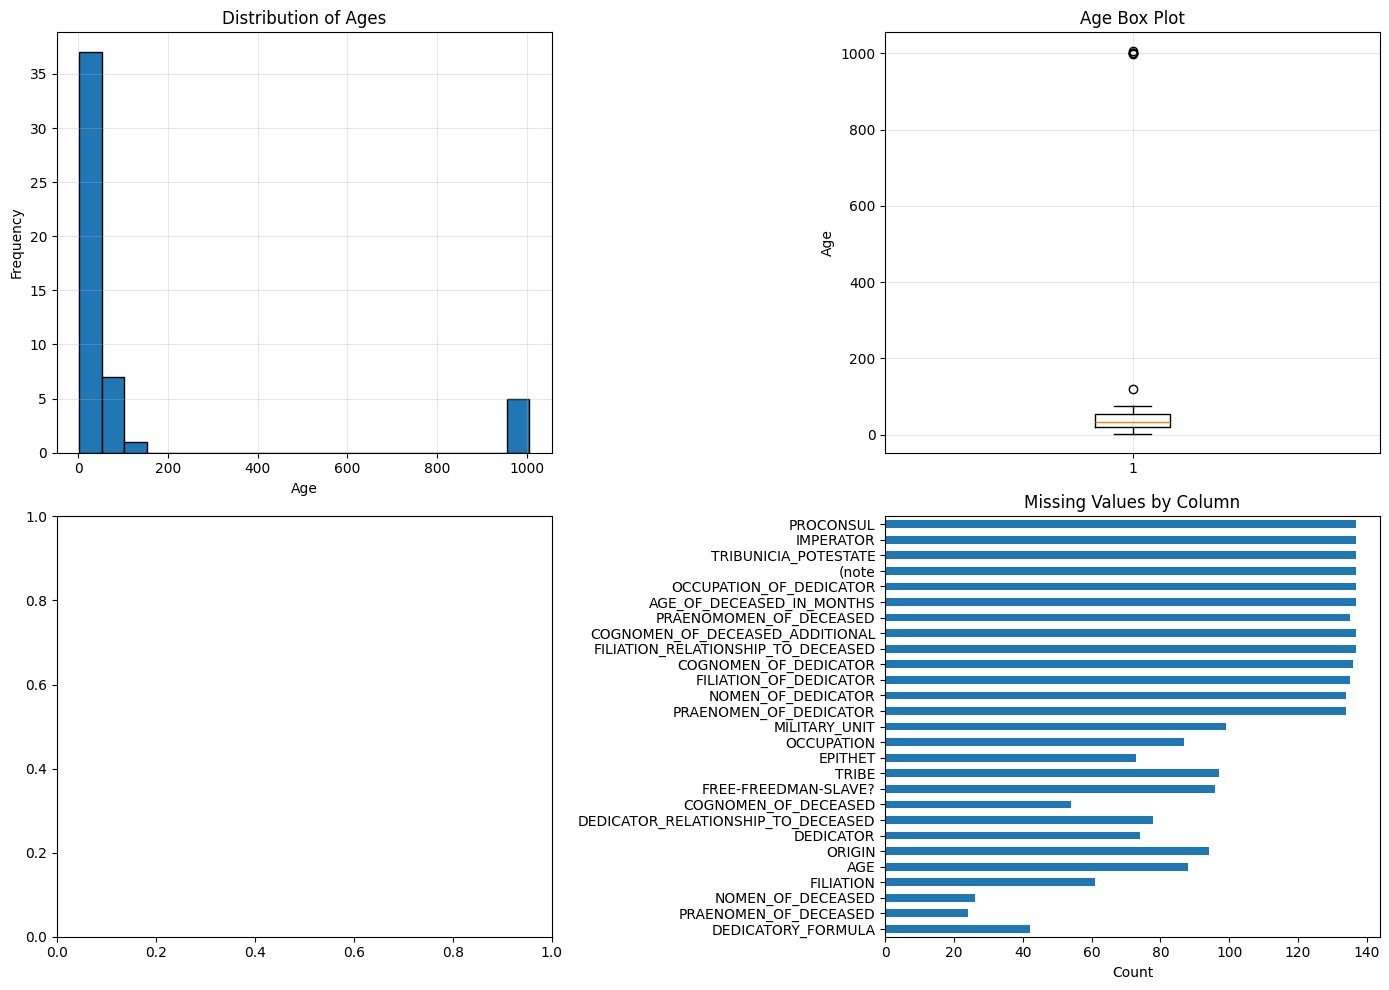


✓ Visualization saved to inscription_analysis.png


In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic statistics
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\n=== AGE Statistics ===")
print(df['AGE'].describe())

# Value counts for categorical columns (adjust column names to match your data)
print("\n=== Top Values by Column ===")
for col in df.columns:
    if col != 'id' and df[col].dtype == 'object':
        print(f"\n{col}:")
        print(df[col].value_counts().head(10))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Age distribution
axes[0, 0].hist(df['AGE'].dropna(), bins=20, edgecolor='black')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Ages')
axes[0, 0].grid(alpha=0.3)

# 2. Age box plot
axes[0, 1].boxplot(df['AGE'].dropna())
axes[0, 1].set_ylabel('Age')
axes[0, 1].set_title('Age Box Plot')
axes[0, 1].grid(alpha=0.3)

# 3. Top 10 values in another categorical column (adjust as needed)
if 'STATUS' in df.columns:
    df['STATUS'].value_counts().head(10).plot(kind='barh', ax=axes[1, 0])
    axes[1, 0].set_title('Top 10 Status Values')
    axes[1, 0].set_xlabel('Count')

# 4. Missing data
missing_counts = df.isnull().sum()
missing_counts[missing_counts > 0].plot(kind='barh', ax=axes[1, 1])
axes[1, 1].set_title('Missing Values by Column')
axes[1, 1].set_xlabel('Count')

plt.tight_layout()
plt.savefig('inscription_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to inscription_analysis.png")